# Mask Detection - Performance Evaluation 

### Imports

In [ ]:
import cv2 as cv
import cv2
import tensorflow as tf
import numpy as np
import sys
import time

from tensorflow.keras.models import load_model
from tensorflow.keras.applications import mobilenet_v2 as mobilenet
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from utilities import apply_boxes, average_precision, iou, get_video_frames, pad_input_image, recover_pad_output


### Constants

In [2]:
H = 562
W = 1000
TARGET_SIZE = (W, H)

In [3]:
model_path = "models/mobilenet_epoch-93_loss-0.0034_val_loss-0.0019.h5"

### Load Models

In [ ]:
#Load face detection model: SSD-MobileNetV2
print("Load face detection model.")
model = load_model("models/retinaface-model")
print("Face detection model loaded.")

#Load mask classification model: MobilenetV2
print("Load mask classification model.")
clf = load_model(model_path)
print("Mask classification model loaded.")

### Frame Extraction from Test Set

In [ ]:
#Extract video frames
print("Extracting frames.")
frames = get_video_frames("video/testset.mp4", target_size = TARGET_SIZE)
print("Frames: ", len(frames))

### Variables

In [6]:
precisions = []
recalls = []
average_precisions = []
true_positives = []

classes = [0, 0, 0]
mean_tps = [0, 0, 0]
mean_ranks = [0, 0, 0]
mean_precisions = [[], [], []]
mean_recalls = [[], [], []]

preds = []
labels = []
times = []

### Read Labels

In [ ]:
#Count classes
print("Counting classes of test set")
for i in range(0, len(frames)):
    for j in range(0,6):
        with open("labels/"+str(i)+"-"+str(j)+".txt", "r") as f:
            lines = f.readlines()
            label = int(lines[3])
            classes[label] = classes[label] + 1

### Run Inference on Test Set

In [ ]:
#Start inference on video frames
show = False
print("Start inference")
for i, frame in enumerate(frames):
    #Start
    start = time.time()
    
    #Preprocess frame
    padded_frame, padding = pad_input_image(frame, 32)
    
    #Face inference
    prediction = model(padded_frame[np.newaxis, ...]).numpy()
    result = recover_pad_output(prediction, padding)

    pred_bboxes = []
    label_bboxes = []
    label_classes = []

    #Save bounding boxes
    for bbox in result:
        x1 = int(bbox[0] * W)
        y1 = int(bbox[1] * H)
        x2 = int(bbox[2] * W)
        y2 = int(bbox[3] * H)
        pred_bboxes.append((x1,y1, x2, y2))

    for j in range(0,6):
        with open("labels/"+str(i)+"-"+str(j)+".txt", "r") as f:
            lines = f.readlines()
            p1 = [int(x) for x in lines[0].replace("[", "").replace("]", "").split(" ")]
            p2 = [int(x) for x in lines[1].replace("[", "").replace("]", "").split(" ")]
            x1, y1 = p1[0], p1[1]
            x2, y2 = p2[0], p2[1]
            label_bboxes.append((x1,y1, x2,y2))
            label = int(lines[3])
            labels.append(label)
            label_classes.append(label)

    #Mask classification inference
    faces = [frame[bbox[1]:bbox[3], bbox[0]:bbox[2]] for bbox in label_bboxes]
    resized_faces = np.array([cv.resize(f, (224, 224), interpolation=cv.INTER_CUBIC) for f in faces])
    processed_faces = mobilenet.preprocess_input(resized_faces)
    predictions = [np.argmax(r) for r in clf.predict(processed_faces)]

    if show:
        show_faces = [frame[bbox[1]:bbox[3], bbox[0]:bbox[2]] for bbox in pred_bboxes]
        show_resized_faces = np.array([cv.resize(f, (224, 224), interpolation=cv.INTER_CUBIC) for f in show_faces])
        show_processed_faces = mobilenet.preprocess_input(show_resized_faces)
        show_predictions = [np.argmax(r) for r in clf.predict(show_processed_faces)]
    
        boxed_frame = apply_boxes(frame, pred_bboxes, show_predictions, margin = 5)
        _img = np.array(boxed_frame)
        cv2.imshow("preview", _img)

    for prediction in predictions:
        preds.append(prediction)

    #Find true positives
    tps = []
    precision = []
    recall = []
    for rank, pred_bbox in enumerate(pred_bboxes):
        tp = False
        for label_bbox in label_bboxes:
            if iou(label_bbox, pred_bbox) > 0.1:
                tp = True

        if tp:
            tps.append(tp)
            true_positives.append(pred_bbox)
            if predictions[rank] == label_classes[rank]:
                mean_tps[label_classes[rank]] = mean_tps[label_classes[rank]] + 1

        precision.append(len(tps)/(rank+1))
        recall.append(len(tps)/6)

        mean_ranks[label_classes[rank]] = mean_ranks[label_classes[rank]] + 1
        mean_precisions[label_classes[rank]].append( mean_tps[label_classes[rank]] / mean_ranks[label_classes[rank]] )
        mean_recalls[label_classes[rank]].append( mean_tps[label_classes[rank]] / classes[label_classes[rank]] )

    #Calculate average precision
    ap = average_precision(precision, recall)
    precisions.append(precision)
    recalls.append(recall)
    average_precisions.append(ap)

    #Finish
    finish = time.time()
    times.append(finish-start)
    print("Elapsed "+str(finish-start)+" for frame "+str(i))
    key = cv.waitKey(20)
    if key == 27:
        break

### Print Results

In [ ]:
print("Medium average precision: "+str(sum(average_precisions) / len(average_precisions)))

rights = []
for pred, label in zip(preds, labels):
    if pred == label:
        rights.append(pred)

print("Accuracy: "+str(len(rights) / len(labels)))
cm = confusion_matrix(labels, preds)
print("Confusion matrix:\n", cm)
_, counts = np.unique(labels, return_counts=True)
mca = np.mean(cm.diagonal() / counts)
print("Mean class accuracy: "+str(mca))
print()

ap0 = average_precision(mean_precisions[0], mean_recalls[0])
ap1 = average_precision(mean_precisions[1], mean_recalls[1])
ap2 = average_precision(mean_precisions[2], mean_recalls[2])

print("Average Precision on class 0 (no mask): "+str(ap0))
print("Average Precision on class 1 (mask): "+str(ap1))
print("Average Precision on class 2 (incorrect mask): "+str(ap2))
print()

print("Average inference time: " +str(sum(times) / len(times)))

with open("outputs/"+model_path[6:]+".txt", "w") as f:
    f.write("Model "+model_path+"\n\n\n")
    f.write("Medium average precision: "+str(sum(average_precisions) / len(average_precisions))+"\n")
    f.write("Accuracy: "+str(len(rights) / len(labels))+"\n")
    f.write("Confusion matrix:\n"+str(cm)+"\n\n")
    f.write("Mean class accuracy: "+str(mca))
    f.write("Average Precision on class 0 (no mask): "+str(ap0)+"\n")
    f.write("Average Precision on class 1 (mask): "+str(ap1)+"\n")
    f.write("Average Precision on class 2 (incorrect mask): "+str(ap2)+"\n")
    f.write("Average inference time: " +str(sum(times) / len(times)))

In [10]:
from matplotlib import pyplot as plt
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):

    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label'.format(accuracy, misclass))
    plt.show()

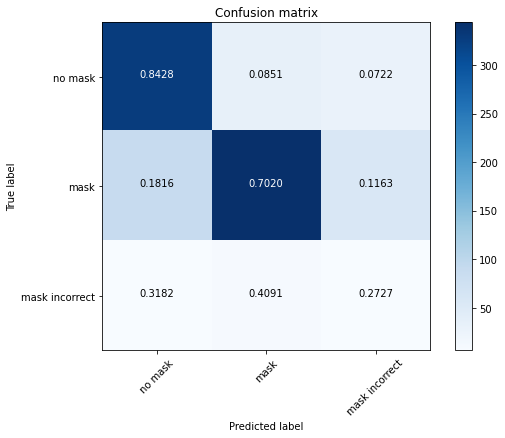

In [11]:
plot_confusion_matrix(cm, ["no mask", "mask", "mask incorrect"])